In [7]:
import pandas as pd 
df = pd.read_excel(r"C:\Users\HP\Desktop\CAIC IITD\Amazon.xlsx")  
df.head()


,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [13]:
import math
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
split_index = math.floor(0.8 * len(df))
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]
print(f"Total rows: {len(df)}")
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)


Total rows: 5153
Training set size: 4122
Testing set size: 1031


Linear Regression Model

In [25]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
closing_prices = df['Close']
for i in range(1, 6):
    df[f'lag_{i}'] = closing_prices.shift(i)
df = df.dropna().reset_index(drop=True)
X = df[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
y = df['Close']


In [31]:
split_index = int(0.8 * len(df))  

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [33]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [35]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 109.2322
R² Score: 0.9981


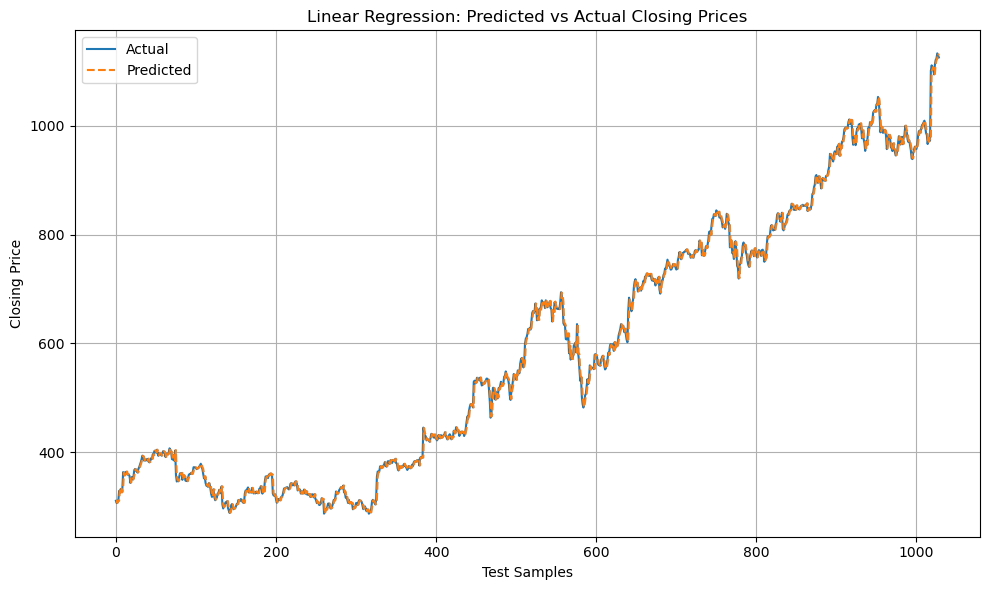

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title("Linear Regression: Predicted vs Actual Closing Prices")
plt.xlabel("Test Samples")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ARIMA Model

In [43]:
from statsmodels.tsa.arima.model import ARIMA
series = df['Close']
split_index = int(0.8 * len(series))
train_data = series[:split_index]
test_data = series[split_index:]
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data))

ARIMA Mean Squared Error: 134543.0858


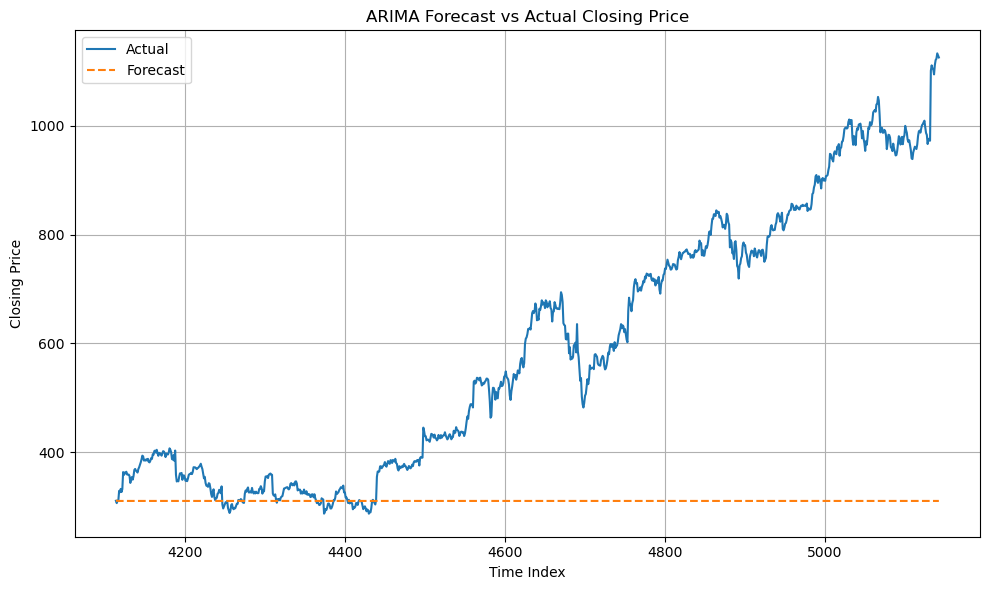

In [45]:
mse = mean_squared_error(test_data, forecast)
print(f"ARIMA Mean Squared Error: {mse:.4f}")

plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual Closing Price')
plt.xlabel('Time Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest

In [47]:
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = compute_rsi(df['Close'])
df = df.dropna().reset_index(drop=True)


features = ['MA7', 'MA30', 'RSI']
X = df[features]
y = df['Close']


In [49]:
split_index = int(0.8 * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [55]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


Random Forest MSE: 128976.1327
Random Forest R²: -1.2557


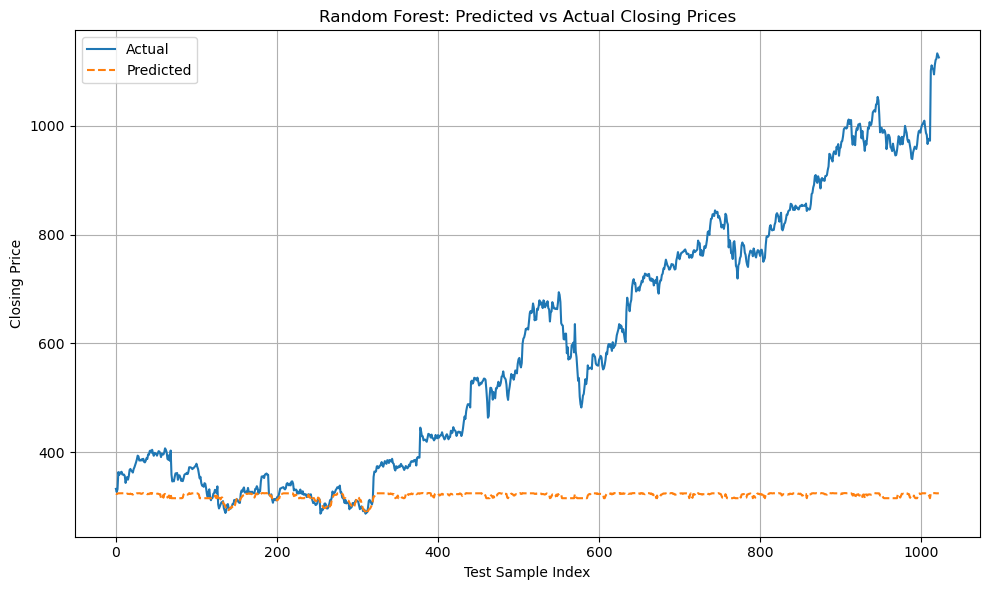

In [57]:

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MSE: {mse:.4f}")
print(f"Random Forest R²: {r2:.4f}")

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Direction Prediction

In [59]:
def direction_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct = (actual_direction == predicted_direction).sum()
    return correct / len(actual_direction)


In [89]:
from sklearn.metrics import mean_absolute_error
import numpy as np
mae_lr = mean_absolute_error(y_test, y_pred)
dir_acc_lr = direction_accuracy(y_test.values, y_pred)
print("Linear Regression")
print(f"MAE: {mae_lr:.4f}")
print(f"Direction Accuracy: {dir_acc_lr:.4%}")


Linear Regression
MAE: 270.5418
Direction Accuracy: 51.4677%


In [71]:
mae_arima = mean_absolute_error(test_data, forecast)
dir_acc_arima = direction_accuracy(test_data.values, forecast)
print("ARIMA")
print(f"MAE: {mae_arima:.4f}")
print(f"Direction Accuracy: {dir_acc_arima:.4%}")


ARIMA
MAE: 279.2793
Direction Accuracy: 1.4591%


In [73]:
mae_rf = mean_absolute_error(y_test, y_pred)
dir_acc_rf = direction_accuracy(y_test.values, y_pred)
print("Random Forest")
print(f"MAE: {mae_rf:.4f}")
print(f"Direction Accuracy: {dir_acc_rf:.4%}")


Random Forest
MAE: 270.5418
Direction Accuracy: 51.4677%


Both Linear Regression and Random Forest is the best performing model from the above and ARIMA model is the least performing one.From the 2 best performing model I shall choose Random Forest for further analysis

Backtesting of Random Forest Model

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)
signals = (y_pred > y_test).astype(int) 
actual_returns = y_test.pct_change().fillna(0)
strategy_returns = signals.shift(1).fillna(0) * actual_returns  
cumulative_strategy_returns = (1 + strategy_returns).cumprod()
cumulative_market_returns = (1 + actual_returns).cumprod()


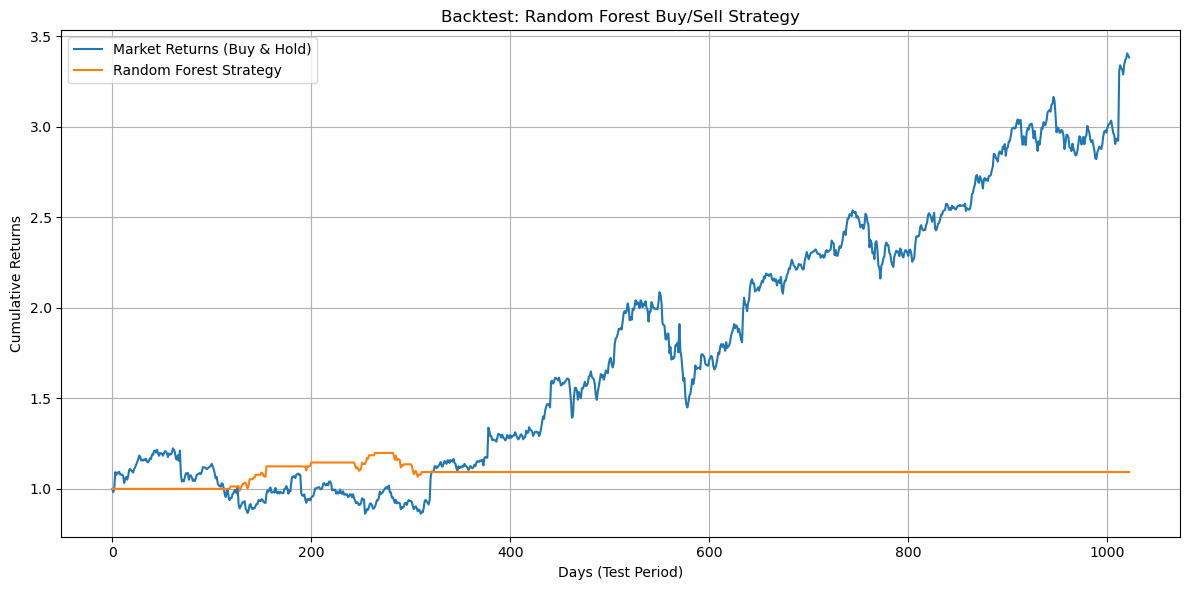

In [79]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_market_returns, label='Market Returns (Buy & Hold)')
plt.plot(cumulative_strategy_returns, label='Random Forest Strategy')
plt.title("Backtest: Random Forest Buy/Sell Strategy")
plt.xlabel("Days (Test Period)")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
final_strategy_return = cumulative_strategy_returns.iloc[-1]
final_market_return = cumulative_market_returns.iloc[-1]

print(f"Final Strategy Return: {final_strategy_return:.4f}x")
print(f"Final Market Return: {final_market_return:.4f}x")
print(f"Total Buy Signals: {signals.sum()}")


Final Strategy Return: 1.0932x
Final Market Return: 3.3841x
Total Buy Signals: 63


Hypothetical Profit and Loss over the test period

In [85]:
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)
signals = (y_pred > y_test).astype(int)
signals = signals.shift(1).fillna(0)
price_change = y_test.diff().fillna(0)
daily_pnl = signals * price_change
cumulative_pnl = daily_pnl.cumsum()

total_profit = cumulative_pnl.iloc[-1]
print(f"Total Hypothetical Profit over test period: ₹{total_profit:.2f}")


Total Hypothetical Profit over test period: ₹26.86


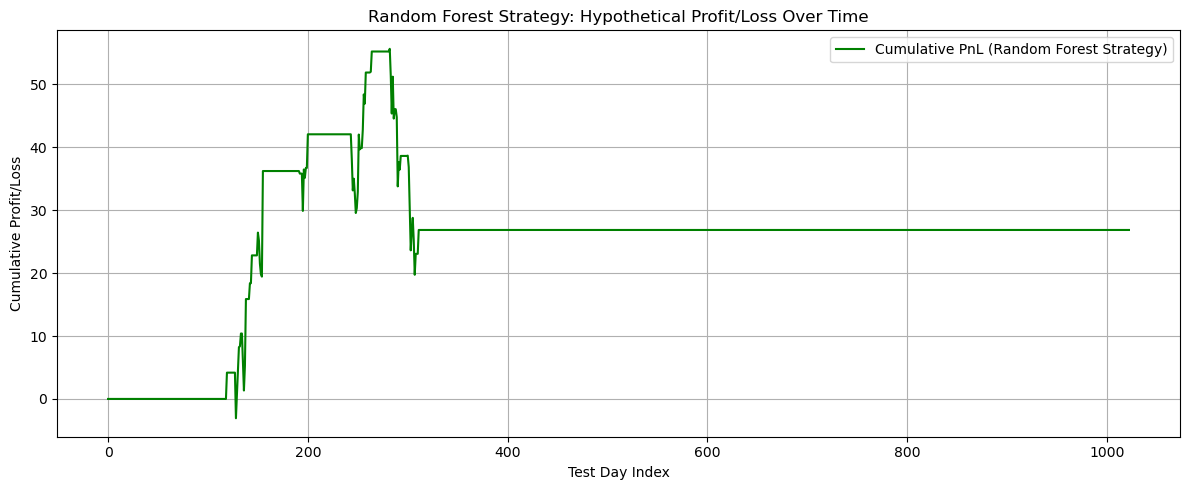

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(cumulative_pnl, label='Cumulative PnL (Random Forest Strategy)', color='green')
plt.title("Random Forest Strategy: Hypothetical Profit/Loss Over Time")
plt.xlabel("Test Day Index")
plt.ylabel("Cumulative Profit/Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
